# Testing stochastic gradient descent method with simplest possible model.
2017-10-02

It is clear that the likelihood landscape is degenerate when you have incompatible conditions. Here, it seems that many of the solutions are rather similar in terms of probabilities. 

It's not clear how one could titrate between the incompatible conditions (imagine that each condition is a corner of some high dimensional contour and that we could change the problem by putting different weights on the conditions). For example, in the limit where we take only one of these conditions at a time, we will find that the solution can be very different from including it. The simple case with three is to imagine that we only observe the pairwise correlations of two spins at a time. This will set the third coupling=0, whereas in reality it is quite different from 0.

So what does it mean to make a condition more believable or not? If we put a weight on the different data points when we are maximizing likelihood, that doesn't do much because the quantities are normalized by the number of data points where they're true. But we could put a constant that goes to zero in the objective function.

In [14]:
# Setup iPython environment.
%pylab inline
plt.rc('font',size=20)

%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
# Import common libraries.
from __future__ import division
from solvers import *
from utils import *
from test import *
import ising_eqn_3_sym
from scipy.optimize import minimize
from entropy import *
from itertools import combinations
from scipy.spatial.distance import pdist,squareform

# Define common functions.
calc_e,calc_observables,mchApproximation = define_ising_helpers_functions()

# Generate example data set.
n = 3  # system size
np.random.seed(0)
h,J = np.random.normal(scale=.1,size=n),np.random.normal(scale=.1,size=n*(n-1)//2)  # random fields, couplings
hJ = np.concatenate((h,J))
p = ising_eqn_3_sym.p(hJ)  # probability distribution of all states p(s)
sisjTrue = ising_eqn_3_sym.calc_observables(hJ)  # exact magnetizations and pairwise correlations

ALL_STATES = bin_states(n,True)  # all 2^n possible binary states in {-1,1} basis

# Construct an impossible probability distribution.
multipleOf = 30
sample = np.zeros((multipleOf*3,3))
sample[:multipleOf,:2] = 1
sample[multipleOf-1,0] = -1
sample[multipleOf:2*multipleOf,1:] = 1
sample[2*multipleOf-1,1] = -1
sample[2*multipleOf:,0] = 1
sample[2*multipleOf:,2] = -1
sample[-1,2] = 1

# A real probabilit ydistribution.
# sample = ALL_STATES[np.random.randint(2**n,size=100)]

sample = vstack((sample,-sample))
sisj = pair_corr(sample,concat=True,exclude_empty=True)

# Are the triplet probability distributions consistent? No!
for i,j,k in combinations(range(n),3):
    if did_all_pairs_vote(sample,i,j,k):
        print check_triplet(sample[:,[i,j,k]])

False


# Degeneracy of solutions.
Depending on the method used to find the minimum, it seems that we can find many different minima.

In [38]:
# Exact solution.
def calc_observables_multipliers(J):
    """
    Calculate observables from probability distribution given Langrangian multipliers.
    """
    E = calc_e(ALL_STATES,J)
    return pair_corr( ALL_STATES, np.exp(-E-logsumexp(-E)),concat=True )

# Declare and call solver.
solver = Exact(n,
               calc_observables_multipliers=calc_observables_multipliers,
               calc_observables=calc_observables)
np.random.seed(0)
exactsolns = []
for i in xrange(10):
    exactsoln,soln = solver.solve(constraints=sisj,
                                  initial_guess=np.random.normal(scale=.5,size=len(hJ)),
                                  fsolve_kwargs={'method':'L-BFGS-B'})
    exactsolns.append(exactsoln)

In [39]:
# Exact solution. Why a unique solution??
for exactsoln in exactsolns:
    tester = Tester(sample,exactsoln.copy())
    print tester.error()
print conditional_likelihood(sample,tester.lamda)

2.24719483224e-05
0.000107769648794
1.08102760185e-05
1.24968046102e-05
2.36074832552e-05
4.60842513687e-06
5.78256164307e-06
9.58718872574e-06
4.01469021195e-06
6.19923267362e-06
-201.909095359


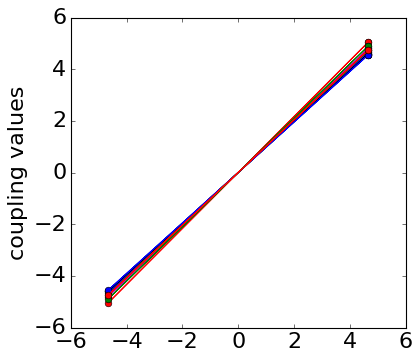

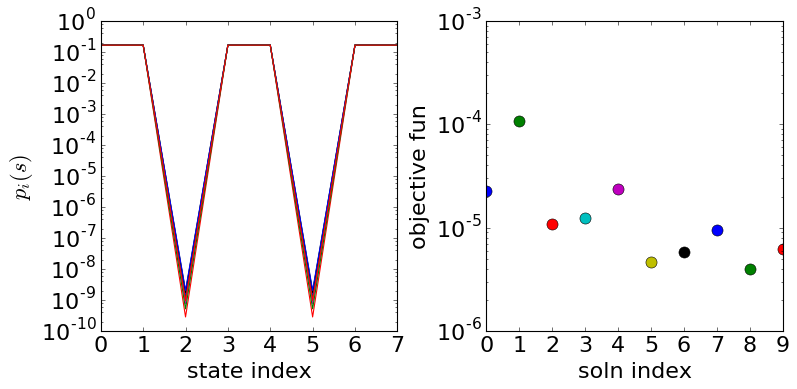

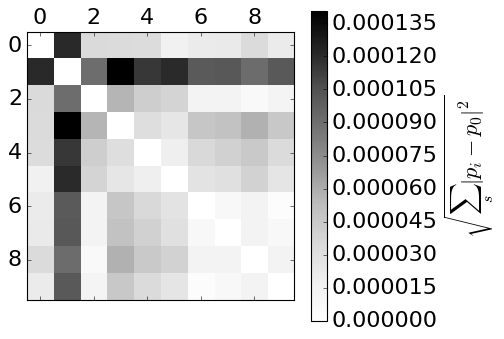

In [40]:
fig,ax = plt.subplots(figsize=(5.4,5))
for s in exactsolns:
    ax.plot(exactsolns[0][3:],s[3:],'o-')
ax.set(ylabel='coupling values')

p = np.zeros((len(exactsolns),8))
for i,s in enumerate(exactsolns):
    p[i] = ising_eqn_3_sym.p(s)
    
fig,ax = plt.subplots(figsize=(11,5),ncols=2)
ax[0].semilogy(p.T)
ax[0].set(ylim=(1e-10,1))
for i,s in enumerate(exactsolns):
    tester.lamda = s
    ax[1].semilogy(i,tester.error(),'o',ms=10)
ax[0].set(ylabel=r'$p_i(s)$',xlabel='state index')
ax[1].set(xlabel='soln index',ylabel='objective fun')
fig.subplots_adjust(wspace=.3)
    
# Distance between probability distributions is pretty small.
fig,ax = plt.subplots(figsize=(5.4,5))
cax = ax.matshow( squareform(pdist(p)),cmap=plt.cm.Greys )
fig.colorbar(cax,label=r'$\sqrt{\sum_s |p_i-p_0|^2}$')

In [28]:
tester = Tester(sample,hJ.copy())

# Using scipy.optimize.minimize.
w1,w2,w3 = 1,1,1
weights = np.array([1,1,1,w1,w2,w3],dtype=float)
def f(params):
    tester.lamda = params
    return tester.error(weights=weights),tester.calc_grad(weights=weights)

# Try a bunch of random starting locations to see if we get many answers.
# CG seems to be really good at finding a minimum but it is also rather expensive
np.random.seed(0)
solns = []
for i in xrange(5):
    solns.append( minimize(f,random.normal(scale=.5,size=len(hJ)),
                           jac=True) )

In [29]:
# None of the solutions can satisfy all the conditions.
for s in solns:
    print s['fun'],s['status']
    tester.lamda = s['x']
#     print conditional_likelihood(sample,tester.lamda)

2.70481155623e-07 2
5.98505525571e-07 2
2.01287887085e-07 2
4.22282565225e-07 2
1.31234358386e-07 2


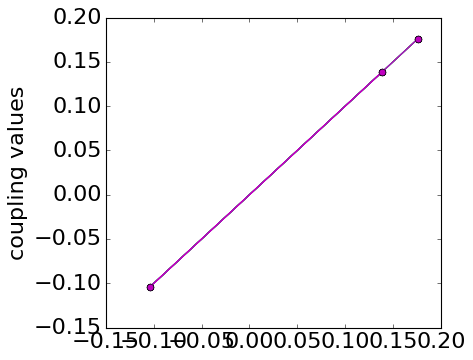

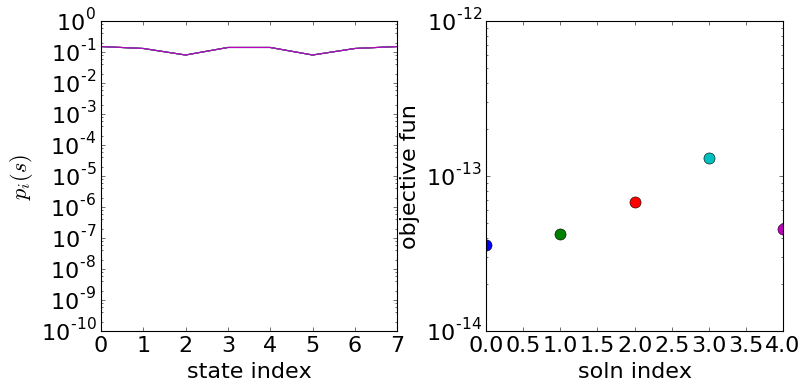

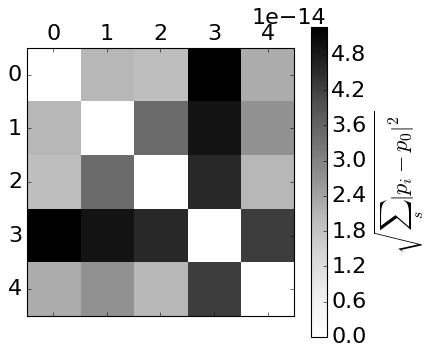

In [132]:
# When everything is consistent, we get exactly what we expect. All the solution converge to the 
# unique solution.
fig,ax = plt.subplots(figsize=(5.4,5))
for s in solns:
    ax.plot(solns[0]['x'][3:],s['x'][3:],'o-')
ax.set(ylabel='coupling values')

p = np.zeros((len(solns),8))
for i,s in enumerate(solns):
    p[i] = ising_eqn_3_sym.p(s['x'])
    
fig,ax = plt.subplots(figsize=(11,5),ncols=2)
ax[0].semilogy(p.T)
ax[0].set(ylim=(1e-10,1))
for i,s in enumerate(solns):
    ax[1].semilogy(i,s['fun'],'o',ms=10)
ax[0].set(ylabel=r'$p_i(s)$',xlabel='state index')
ax[1].set(xlabel='soln index',ylabel='objective fun')
fig.subplots_adjust(wspace=.3)
    
# Distance between probability distributions is pretty small.
fig,ax = plt.subplots(figsize=(5.4,5))
cax = ax.matshow( squareform(pdist(p)),cmap=plt.cm.Greys )
fig.colorbar(cax,label=r'$\sqrt{\sum_s |p_i-p_0|^2}$')

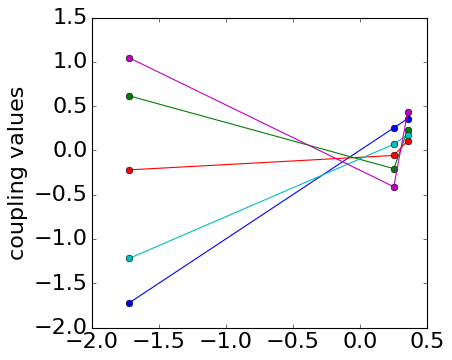

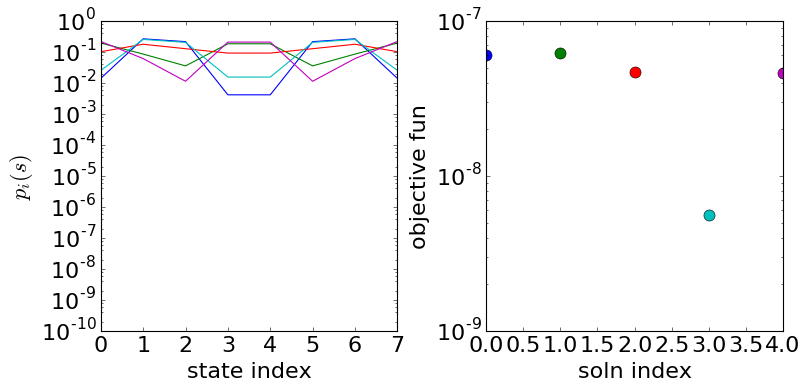

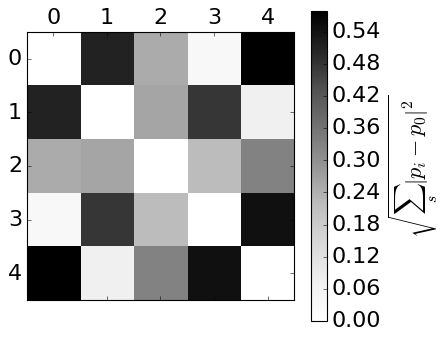

In [135]:
# When the sample comes from a consistent probability distribution, but we don't put enough constraints,
# we get a lot of degeneracy in the solution.
fig,ax = plt.subplots(figsize=(5.4,5))
for s in solns:
    ax.plot(solns[0]['x'][3:],s['x'][3:],'o-')
ax.set(ylabel='coupling values')

p = np.zeros((len(solns),8))
for i,s in enumerate(solns):
    p[i] = ising_eqn_3_sym.p(s['x'])
    
fig,ax = plt.subplots(figsize=(11,5),ncols=2)
ax[0].semilogy(p.T)
ax[0].set(ylim=(1e-10,1))
for i,s in enumerate(solns):
    ax[1].semilogy(i,s['fun'],'o',ms=10)
ax[0].set(ylabel=r'$p_i(s)$',xlabel='state index')
ax[1].set(xlabel='soln index',ylabel='objective fun')
fig.subplots_adjust(wspace=.3)
    
# Distance between probability distributions is pretty small.
fig,ax = plt.subplots(figsize=(5.4,5))
cax = ax.matshow( squareform(pdist(p)),cmap=plt.cm.Greys )
fig.colorbar(cax,label=r'$\sqrt{\sum_s |p_i-p_0|^2}$')

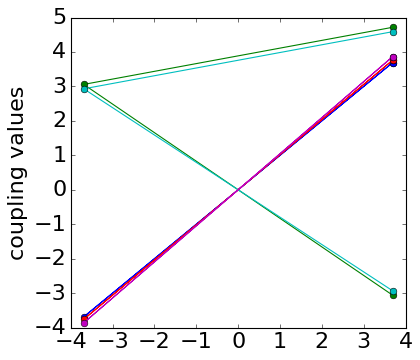

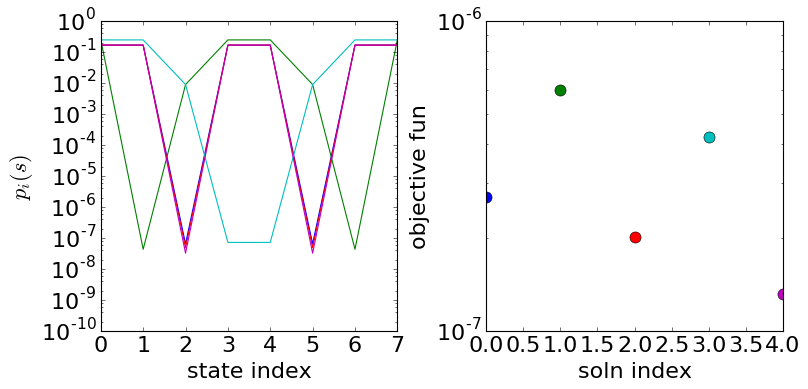

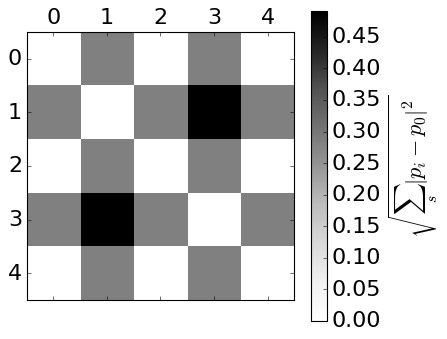

In [30]:
# As soon as we turn on inconsistency, we start getting divergence solutions.
fig,ax = plt.subplots(figsize=(5.4,5))
for s in solns:
    ax.plot(solns[0]['x'][3:],s['x'][3:],'o-')
ax.set(ylabel='coupling values')

p = np.zeros((len(solns),8))
for i,s in enumerate(solns):
    p[i] = ising_eqn_3_sym.p(s['x'])
    
fig,ax = plt.subplots(figsize=(11,5),ncols=2)
ax[0].semilogy(p.T)
ax[0].set(ylim=(1e-10,1))
for i,s in enumerate(solns):
    ax[1].semilogy(i,s['fun'],'o',ms=10)
ax[0].set(ylabel=r'$p_i(s)$',xlabel='state index')
ax[1].set(xlabel='soln index',ylabel='objective fun')
fig.subplots_adjust(wspace=.3)
    
# Distance between probability distributions is pretty small.
fig,ax = plt.subplots(figsize=(5.4,5))
cax = ax.matshow( squareform(pdist(p)),cmap=plt.cm.Greys )
fig.colorbar(cax,label=r'$\sqrt{\sum_s |p_i-p_0|^2}$')

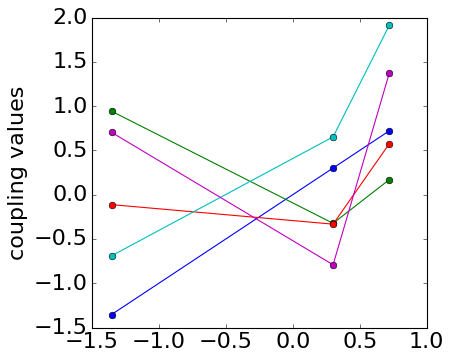

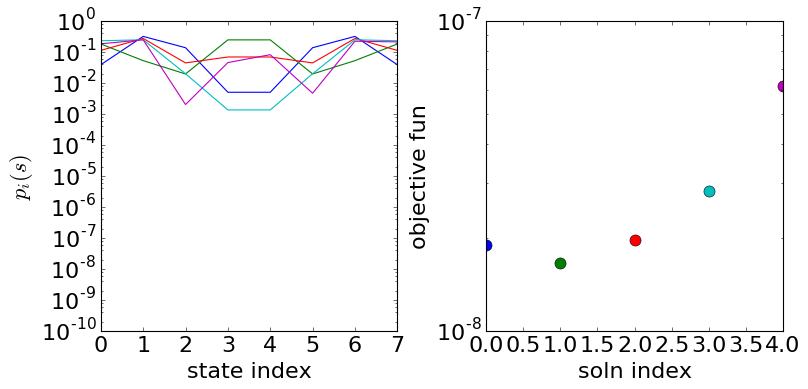

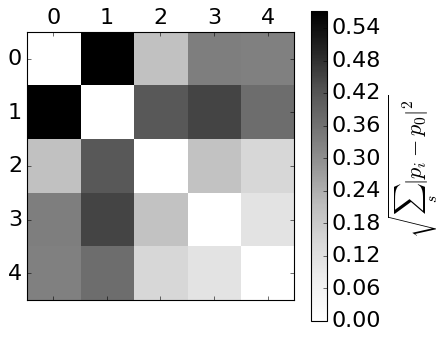

In [125]:
# As soon as we turn on inconsistency, we start getting divergence solutions.
fig,ax = plt.subplots(figsize=(5.4,5))
for s in solns:
    ax.plot(solns[0]['x'][3:],s['x'][3:],'o-')
ax.set(ylabel='coupling values')

p = np.zeros((len(solns),8))
for i,s in enumerate(solns):
    p[i] = ising_eqn_3_sym.p(s['x'])
    
fig,ax = plt.subplots(figsize=(11,5),ncols=2)
ax[0].semilogy(p.T)
ax[0].set(ylim=(1e-10,1))
for i,s in enumerate(solns):
    ax[1].semilogy(i,s['fun'],'o',ms=10)
ax[0].set(ylabel=r'$p_i(s)$',xlabel='state index')
ax[1].set(xlabel='soln index',ylabel='objective fun')
fig.subplots_adjust(wspace=.3)
    
# Distance between probability distributions is pretty small.
fig,ax = plt.subplots(figsize=(5.4,5))
cax = ax.matshow( squareform(pdist(p)),cmap=plt.cm.Greys )
fig.colorbar(cax,label=r'$\sqrt{\sum_s |p_i-p_0|^2}$')

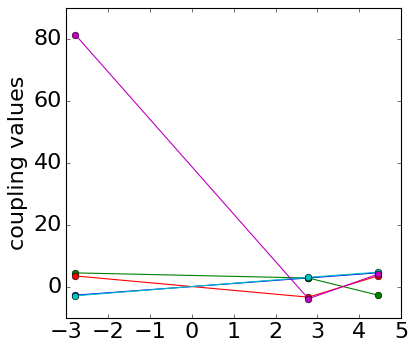

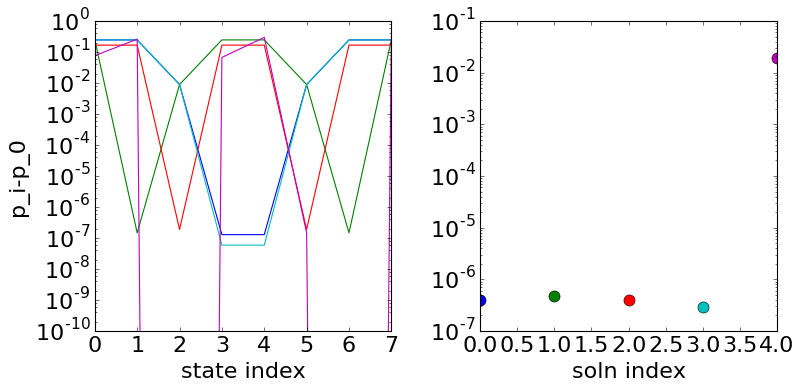

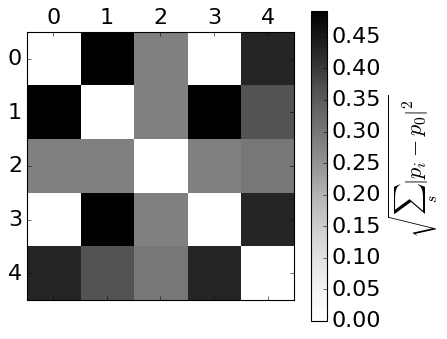

In [121]:
# When there is no weight on the inconsistency, we get very similar solutions (probably 
# difference comes from randomness in initial starting location).
# As soon as we turn on inconsistency, we start getting divergence solutions.
fig,ax = plt.subplots(figsize=(5.4,5))
for s in solns:
    ax.plot(solns[0]['x'][3:],s['x'][3:],'o-')
ax.set(ylabel='coupling values')

p = np.zeros((len(solns),8))
for i,s in enumerate(solns):
    p[i] = ising_eqn_3_sym.p(s['x'])
    
fig,ax = plt.subplots(figsize=(11,5),ncols=2)
ax[0].semilogy(p.T)
ax[0].set(ylim=(1e-10,1))
for i,s in enumerate(solns):
    ax[1].semilogy(i,s['fun'],'o',ms=10)
ax[0].set(ylabel='p_i-p_0',xlabel='state index')
ax[1].set(xlabel='soln index')
fig.subplots_adjust(wspace=.3)
    
# Distance between probability distributions is pretty small.
fig,ax = plt.subplots(figsize=(5.4,5))
cax = ax.matshow( squareform(pdist(p)),cmap=plt.cm.Greys )
fig.colorbar(cax,label=r'$\sqrt{\sum_s |p_i-p_0|^2}$')